# Primitives


### Guided example to calculate expectation values

We need to compute $\langle X \rangle_+$ and $\langle Z \rangle_+$, so we can compute H = 2 $\langle X \rangle_+$ - $\langle Z \rangle_+$

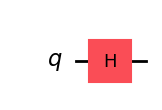

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []

for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl")

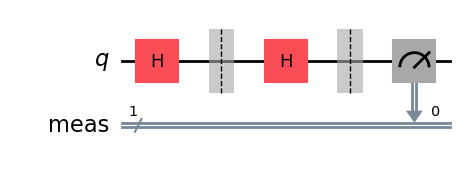

In [6]:
aux_circuits[0].draw("mpl")

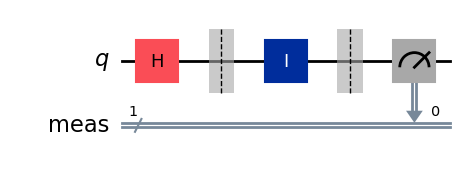

In [7]:
aux_circuits[1].draw("mpl")

We can do the computation manually by "Sampler" and check with "Estimator"

In [37]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, XGate, YGate, ZGate
import numpy as np


## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots=shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []

for pauli in H.paulis:
    val = 0

    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)

    if str(pauli) == "Y":
        Lambda = YGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)

    expvals.append(val)

print("Sampler resutls:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f" >>  Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f" >>  Total expected value: {total_expval:.5f}")


## ESTIMATOR
observables = [
    *H.paulis,H
    # Note: run for individual Paulis as well as full observable H
]

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs in H:
        print(f" >>  Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f" >> Total expected value {expval:.5f}")

Sampler resutls:
 >>  Expected value of X: 1.00000
 >>  Expected value of Z: 0.00540
 >>  Total expected value: 1.99460
Estimator results:
 >> Total expected value 1.00000
 >> Total expected value 0.00000
 >> Total expected value 2.00000


# Cost Functions

All in all, we will be performing a classical optimization loop but relying on the evaluation of the cost function to a quantum computer. From this perspective, one could think of the optimization as a purely classical endeavor where we call some black-box quantum oracle each time the optimizer needs to evaluate the cost function.

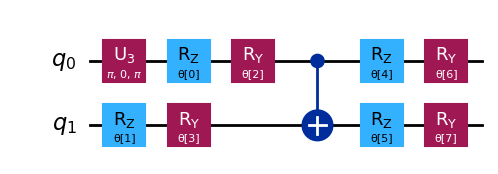

In [39]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator
    
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parametrised ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        
    Returns:
        float: Energy estimate"""
    
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
ansatz.decompose().draw("mpl")

We can carry this out with a simulator: the StatevectorSimulator. This is usually advisable for debugging, but we will immediately follow the debugging run with a calculation on real quantum hardware. Increasingly, problems of interest are no longer classically simulable without state-of-the-art supercomputing facilities.

In [48]:
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[0.99110689]


Now it is run on a real quantum computer. 

One step of particular importance in variational algorithms is the use of a Qiskit Runtime session. Starting a session allows you to run multiple iterations of a variational algorithm without waiting in a new queue each time parameters are updated. This is important if queue times are long and/or many iterations are needed. Only partners in the IBM Quantum Network can use Runtime sessions. 

In [49]:
# Estimated usage: < 1 min. Benchmarked at 7 seconds on ibm_osaka, 5-23-24

from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorOptions, EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Select the least busy backend:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
#Or get a specific backend:
#backend = service.backend("ibm_cusco")
)

# Use a pass manager to transpile the circuit and observable for the specific backend being used:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots=10_000
)

# Open a Runtime session:
with Session(backend=backend) as session:
    estimator = EstimatorV2(mode=session, options = estimator_options)
    cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

session.close()
print(cost)

[1.01854019]


Both values should be similar

### Example mapping to a non-physical system

We can solve the Max-Cut problem:

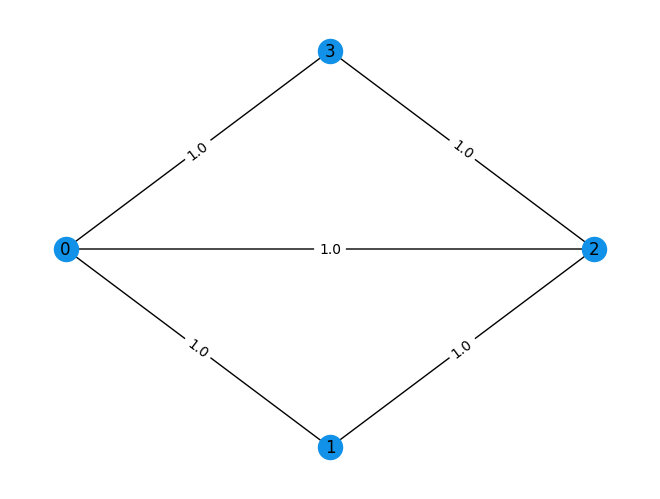

In [50]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

The operator is a linear combination of terms with Z operators on nodes connected by an edge (recall that the 0th qubit is farthest right): IIZZ+IZIZ+IZZI+ZIIZ+ZZII. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the QAOAAnsatz circuit from the Qiskit circuit library.

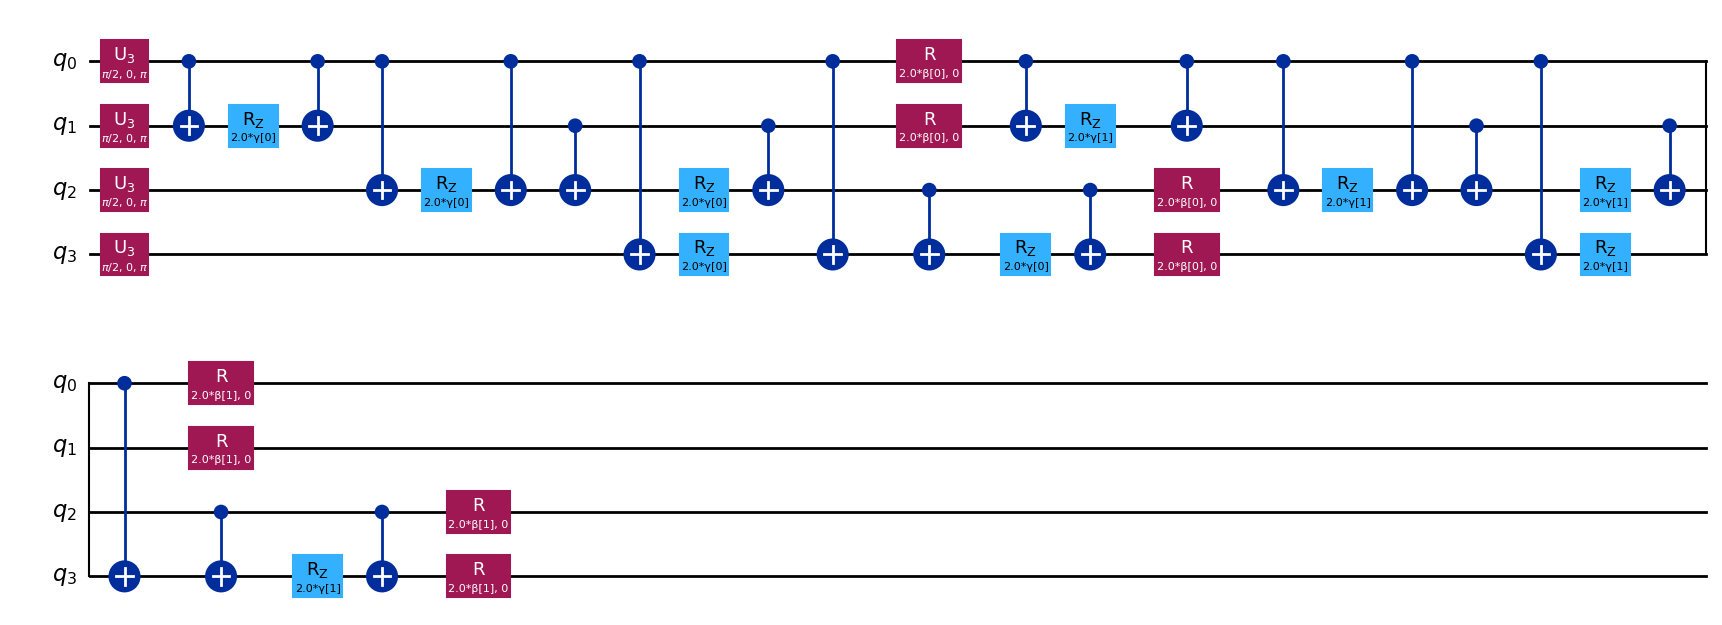

In [52]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw("mpl")

In [53]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


With the Runtime Estimator directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, The cost function for a QAOA instance is quite simple:

In [58]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func(x0, ansatz, hamiltonian, estimator)
print(cost)

0.1844594572179925


In [56]:
#Estimated usage: < 1 min, benchmarked at 6 seconds on ibm_osaka, 5-23-24
#Load some necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

#Select the least busy backend:

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Or get a specific backend:
#backend = service.backend("ibm_cusco")

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_hamiltonian = hamiltonian.apply_layout(layout = isa_ansatz.layout)

# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

# Open a Runtime session:

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)
    cost = cost_func_vqe(x0, isa_ansatz, isa_hamiltonian, estimator)

# Close session after done
session.close()
print(cost)

0.41993835396123413


# Measurement strategy: speed vs accuracy

### Error supression (example for visualisation)

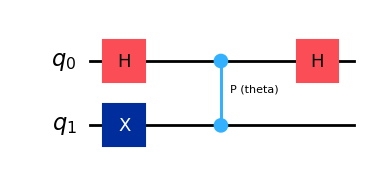

In [59]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

The circuit above can yield sinusoidal expectation values of the observable given, provided we insert phases spanning an appropriate interval, such as [0,2π].

In [60]:
## Setup phase
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

########################################################################################
#     We can use a simulator to show the usefulness of an optimized transpilation.     #
#     We will return below to using real hardware to demonstrate the usefulness of     #
#     error mitigation. We will use QiskitRuntimeService to get a real backend (in     #
#     this case, ibm_sherbrooke), and use AerSimulator to simulate that backend,       #
#     including its noise behavior.                                                    #
########################################################################################

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')

# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

We can now use a pass manager to transpile the circuit into the "instruction set architecture" or ISA of the backend. This is a new requirement in Qiskit Runtime: all circuits submitted to a backend must conform to the constraints of the backend’s target, meaning they must be written in terms of the backend's ISA — i.e., the set of instructions the device can understand and execute. These target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and - when relevant - its pulse and other instruction timing specifications.

Note that in the present case, we will do this twice: once with optimization_level = 0, and once with it set to 3. Each time we will use the Estimator primitive to estimate the expectation values of the observable at different values of phase.



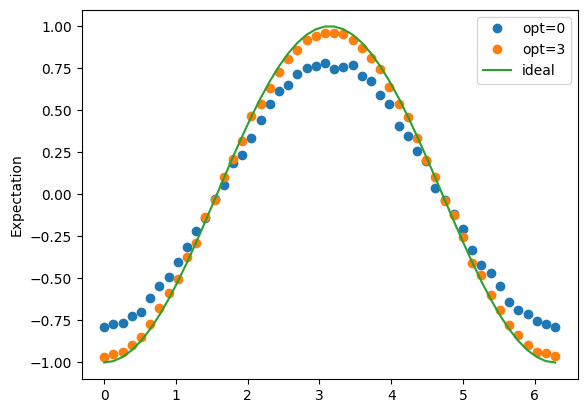

In [64]:
# Import estimator and specify that we are using the simulated backend:

from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend_sim)

circuit = qc

#Use a pass manager to transpile the circuit and observable for the backend being simulated.
#Start with no optimization:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

noisy_exp_vales = []
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_vales = cost[0]

# Repeat the steps above, but now with optimization_level=3

exp_values_with_opt_es = []
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]

##########################################################################################################################################
#    Finally, we can plot the results, and we see that the precision of the calculation was fairly good even without optimization,       #
#    but it definitely improved by increasing optimization to level 3. Note that in deeper, more complicated circuits, the difference    #
#    between optimization levels of 0 and 3 are likely to be more significant. This is a very simple circuit used as a toy model.        #
##########################################################################################################################################

import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_vales, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

### Using Qiskit Runtime's mitigation and suppression options


Here's how to calculate an expectation value while using error mitigation and suppression in Qiskit Runtime. We can make use of precisely the same circuit and observable as before, but this time keeping the optimization level fixed at level 2, and now tuning the resilience or the error mitigation technique(s) being used. This error mitigation process occurs multiple times throughout an optimization loop.

We perform this part on real hardware, since error mitigation is not available on simulators.

C:\Users\Mikel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:863: UserWarning: Your current pending jobs are estimated to consume 379.82247540746437 quantum seconds, but you only have 166 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


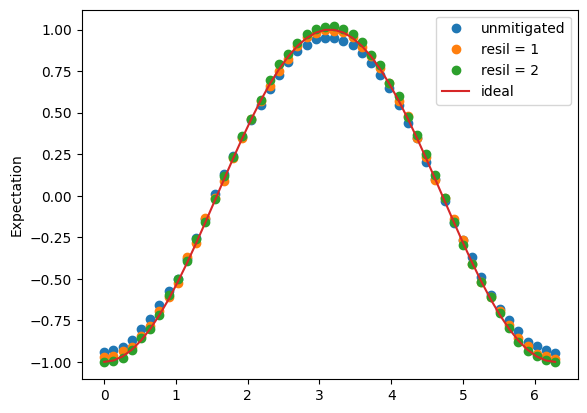

In [66]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, EstimatorOptions, EstimatorV2 as Estimator

# We select the least busy backend

# Select the least busy backend
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

# Or use a specific backend
# backend = service.backend("ibm_cusco")

# Initialise some variables to save the results from different runs:

exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []

# Use a pass manager to optimse the circuit and observables for the backend chosen:

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

# Open a session and run with no error mitigation:

estimator_options = EstimatorOptions(
    resilience_level=0,
    default_shots=10000
)

with Session(backend=backend) as session:


    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em0_es = cost[0]

# Open a session and run with resilience = 1:

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em1_es = cost[0]

# Open a session and run with resilience = 2:

estimator_options = EstimatorOptions(
    resilience_level=2,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)

    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em2_es = cost[0]

import matplotlib.pyplot as plt

plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

# Optimization Loops

### Local and Global Optimizers

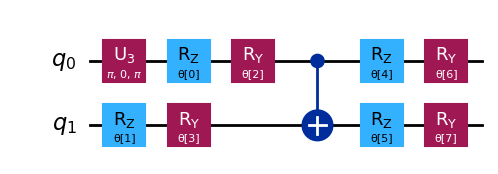

In [68]:
# We'll first setup our problem before exploring each optimizer class:

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

ansatz = reference_circuit.compose(variational_form)
ansatz.decompose().draw("mpl")

### Local Optimizers

Local optimizers search for a point that minimizes the cost function starting at an initial point(s) $C(\vec{\theta}_0)$ and move to different points based on what they observe in the region they are currently evaluating on successive iterations. This implies that the convergence of these algorithms will usually be fast, but can be heavily dependent on the initial point. Local optimizers are unable to see beyond the region where they are evaluating and can be especially vulnerable to local minima, reporting convergence when they find one and ignoring other states with more favorable evaluations.

In [69]:
# Scipy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method='SLSQP')

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.999999996448634
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.566e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [-5.960e-08 -5.960e-08 -7.958e-04  2.545e-04  1.381e-03
            1.381e-03  5.431e-04  5.431e-04]
    nfev: 112
    njev: 12

### Gradient-Based Optimizers


In [70]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="BFGS")

result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.9999999999997415
        x: [ 1.000e+00  1.000e+00  1.571e+00  2.820e-07  2.009e-01
            -2.009e-01  6.342e-01 -6.342e-01]
      nit: 14
      jac: [-2.980e-08  0.000e+00  1.013e-06  9.537e-07  2.682e-07
             2.980e-07  2.980e-08  5.960e-08]
 hess_inv: [[ 1.000e+00  4.048e-11 ...  2.450e-07  1.078e-07]
            [ 4.048e-11  1.000e+00 ...  2.615e-05  2.152e-05]
            ...
            [ 2.450e-07  2.615e-05 ...  7.243e-01 -2.604e-01]
            [ 1.078e-07  2.152e-05 ... -2.604e-01  8.179e-01]]
     nfev: 144
     njev: 16

### Gradient-Free Optimizers

In [73]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.999999988030975
       x: [-2.709e-02  1.153e+00  1.571e+00  3.142e+00  1.866e+00
           -1.276e+00  1.541e+00  1.601e+00]
    nfev: 155
   maxcv: 0.0